In [4]:
import numpy as np
import scipy
from scipy.linalg import expm
import random
import math
import cmath as cm
from scipy.stats import unitary_group
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit, basinhopping
import matplotlib
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.autograd.functional import jacobian, hessian
# import lightning as L
# from lightning.pytorch.loggers import TensorBoardLogger
import torch_optimizer

import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

import torch

In [5]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    


set_random_seed(42)

In [6]:
torch.cuda.is_available()

True

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
def T_pq(N, p, q, phi, theta):
    T = np.eye(N,dtype=np.complex128)
    T[q,q]=cm.exp(1j*phi)*math.sin(theta)*1j*cm.exp(1j*theta*0.5) #with coefficient
    T[q,p]=cm.exp(1j*phi)*math.cos(theta)*1j*cm.exp(1j*theta*0.5)
    T[p,q]=math.cos(theta)*1j*cm.exp(1j*theta*0.5)
    T[p,p]=-math.sin(theta)*1j*cm.exp(1j*theta*0.5)
    return T

def Reck_extand(N, phases, phases_last):
    k=0
    U=np.eye(N, dtype=np.complex128)
    # pairs = [[phases[i], phases[i+1]] for i in range(len(phases) - 1)]
    for p in range(1, N):
        for q in range(0, p):
            # U=U.dot(T_pq(N, p, q, pairs[k][0], pairs[k][1])) #be aware of precise phase sequence!!!
            U=U.dot(T_pq(N, p, q, phases[k,0], phases[k,1]))
            k+=1
    D=np.eye(N, dtype=np.complex128)
    for i in range(N-1):
        D[i,i]=cm.exp(1j*phases_last[i])
    U=U.dot(D)
#    return U
    return linalg.inv(U)

def Reck_decomposition_extand(weights, N):
    reck=weights
    phases=[]
    for i in range(1,N):
        for j in range(0, i):
            phi=cm.phase(reck[j,i])-cm.phase(reck[j,j])
            theta=math.atan(abs(reck[j,j])/abs(reck[j,i]))
            reck=reck.dot(T_pq(N,i,j,phi,theta))
            phases.append([phi,theta])
    phases=np.reshape(phases,[N*(N-1)//2,2])
    global_phase=cm.phase(reck[N-1,N-1])
    D=np.eye(N, dtype=complex)
    for i in range(N-1):
        D[i,i]=cm.exp(1j*(-cm.phase(reck[i,i])+global_phase))
    phases_last=[]
    for i in range(N-1):
        phases_last.append(cm.phase(D[i,i]))
    phases_last=np.array(phases_last)
    return phases, phases_last

def T_pq_torch(N, p, q, phi, theta, device='cuda'):
    T = torch.eye(N, dtype=torch.complex128, device=device)
    T[q,q]=torch.exp(1j*phi)*torch.sin(theta)*1j*torch.exp(1j*theta*0.5) #with coefficient
    T[q,p]=torch.exp(1j*phi)*torch.cos(theta)*1j*torch.exp(1j*theta*0.5)
    T[p,q]=torch.cos(theta)*1j*torch.exp(1j*theta*0.5)
    T[p,p]=-torch.sin(theta)*1j*torch.exp(1j*theta*0.5)
    return T

def Reck_extand_torch(N, phases, device, phases_last):
    k=0
    # pairs = [[phases[i], phases[i+1]] for i in range(len(phases) - 1)]
    U=torch.eye(N, dtype=torch.complex128, device=device)
    for p in range(1, N):
        for q in range(0, p):
            # U=U @ T_pq_torch(N, p, q, torch.tensor(pairs[k][0], dtype = torch.float32, device=device), torch.tensor(pairs[k][1], dtype = torch.float32, device=device), device=device)
            U=U @ T_pq_torch(N, p, q, torch.tensor(phases[k][0], dtype = torch.float32, device=device), torch.tensor(phases[k][1], dtype = torch.float32, device=device), device=device)
            k+=1
    D=torch.eye(N, dtype=torch.complex128, device=device)
    for i in range(N-1):
        D[i,i]=cm.exp(1j*phases_last[i])
    U=U @ D
#    return U
    return torch.linalg.inv(U)

def Haar_Random_U(n):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return q

def Haar_Random_U_torch(n):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return torch.tensor(q)

def Is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

def Is_unitary_torch(m, device='cuda'):
    return torch.allclose(torch.eye(m.shape[0],dtype=torch.complex128, device=device), m.mH @ m)

def h_product(x, y):
    x = np.matrix(x)
    xH = x.getH()
    C = np.matrix(xH)*np.matrix(y)
    #C = x * y
    return (np.trace(C))


def h_product_torch(x, y):
    #x = np.matrix(x)
    xH = x.mH
    C = xH @ y
    #C = x * y
    return torch.trace(C)

def FM(x, y):
    return (h_product(x, y) * h_product(y, x)) / (h_product(x, x) * h_product(y, y))

def FM_torch(x, y):
    return (h_product_torch(x, y) * h_product_torch(y, x)) / (h_product_torch(x, x) * h_product_torch(y, y))

In [24]:
N=3
U=Haar_Random_U(N)

In [25]:
phases_dec, phases_last=Reck_decomposition_extand(U, N)
print(phases_dec)
print(phases_last)

[[-1.0601144   1.41875138]
 [ 1.65229766  0.94108381]
 [ 1.99637189  0.75892734]]
[-1.50826084  0.73320692]


In [26]:
U_reck = Reck_extand_torch(N, phases=phases_dec, device=device, phases_last=phases_last)

In [37]:
FM(torch.tensor(U, dtype=torch.complex128, device=device), U_reck)

tensor(1.0000+1.2161e-17j, device='cuda:0', dtype=torch.complex128)

In [35]:
U

array([[ 0.22261261-0.7672299j , -0.08588912-0.08721871j,
        -0.00774953+0.58886145j],
       [ 0.20982016+0.36623789j, -0.02598253-0.69086681j,
         0.50481986+0.29837924j],
       [-0.12326114-0.41043136j,  0.35195974-0.61900586j,
        -0.1663564 -0.5306924j ]])

In [36]:
U_reck

tensor([[-0.7712+0.2083j, -0.0299+0.1187j,  0.5072-0.2993j],
        [ 0.2039-0.3695j, -0.5768+0.3811j, -0.0073-0.5864j],
        [-0.2867+0.3185j, -0.7118+0.0208j, -0.3671+0.4178j]], device='cuda:0',
       dtype=torch.complex128)

In [34]:
torch.allclose(torch.tensor(U, dtype=torch.complex128, device=device), U_reck)

False

In [51]:
phases_dec, phases_last=Reck_decomposition_extand(U, N)
print(U)


U_reck = Reck_extand(N, phases=phases_dec, phases_last=phases_last)
# U_reck=np.matrix(U_reck)
print(U_reck)
# print(Is_unitary_torch(U_reck, device=device))
print(FM(U, U_reck))

[[ 0.22261261-0.7672299j  -0.08588912-0.08721871j -0.00774953+0.58886145j]
 [ 0.20982016+0.36623789j -0.02598253-0.69086681j  0.50481986+0.29837924j]
 [-0.12326114-0.41043136j  0.35195974-0.61900586j -0.1663564 -0.5306924j ]]
[[-0.77122854+0.20833778j -0.02990984+0.11869898j  0.50719923-0.29927714j]
 [ 0.20394855-0.36953982j -0.57683835+0.38108996j -0.00728074-0.58636188j]
 [-0.2866765 +0.31853382j -0.7117659 +0.0208138j  -0.36705089+0.41783073j]]
(1.0000000000000002+0j)


In [24]:
data = []
data_no_current = []
for ch in range(4):
    for H in range(3):
        with open(f"Calibration Example_915\ch{ch + 1}_H{H + 1}.txt") as file:
            for line in file:
                try:
                    row = [float(num) for num in line.split()]
                    if row[0] % 40 == 0:
                        data.append([ch,H] + row)
                    # if row[0] < 420:
                    #     if row[0] % 40 == 0:
                    #         data.append([ch,H] + row)
                    else:
                        continue
                    if row[0] == 0:
                        data_no_current.append([ch,H] + row)
                except:
                    pass

def create_un_mat_torch(v, device):

    Mc = torch.zeros((4, 4), dtype=torch.complex128, device=device)

    Mc[0, 1] = v[0] + 1j * v[1]
    Mc[1, 0] = v[0] - 1j * v[1]

    Mc[0, 2] = v[2] + 1j * v[3]
    Mc[2, 0] = v[2] - 1j * v[3]

    Mc[0, 3] = v[4] + 1j * v[5]
    Mc[3, 0] = v[4] - 1j * v[5]

    Mc[1, 2] = v[6] + 1j * v[7]
    Mc[2, 1] = v[6] - 1j * v[7]

    Mc[1, 3] = v[8] + 1j * v[9]
    Mc[3, 1] = v[8] - 1j * v[9]

    Mc[2, 3] = v[10] + 1j * v[11]
    Mc[3, 2] = v[10] - 1j * v[11]

    U_torch = torch.matrix_exp(1j * Mc)
    return U_torch

def create_un_mat_numpy(v):
    Mc = np.zeros((4, 4),dtype=np.complex128)
    Mc[0][1] = v[0] + 1j * v[1]
    Mc[1][0] = v[0] - 1j * v[1]
    
    Mc[0][2] = v[2] + 1j * v[3]
    Mc[2][0] = v[2] - 1j * v[3]
    
    Mc[0][3] = v[4] + 1j * v[5]
    Mc[3][0] = v[4] - 1j * v[5]

    Mc[1][2] = v[6] + 1j * v[7]
    Mc[2][1] = v[6] - 1j * v[7]

    Mc[1][3] = v[8] + 1j * v[9]
    Mc[3][1] = v[8] - 1j * v[9]

    Mc[2][3] = v[10] + 1j * v[11]
    Mc[3][2] = v[10] - 1j * v[11]
    
    U = expm(1j * Mc)
    
    return U

def f_torch(v, data):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]

    current_coefficient = 0.005

    cost = torch.tensor(0.0, dtype=torch.float32, device=device)

    for i in data:
        x = torch.zeros(3, dtype=torch.float32, device=device)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def f_torch_no_data(v, data=data):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]
    cost = torch.tensor(0.0, dtype=torch.double, device=device)

    current_coefficient = 0.005

    for i in data:
        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def f_torch_no_data_Reck(v, data=data):

    M1 =  Reck_extand_torch(4, v[:12], device, v[12:15])
    M2 =  Reck_extand_torch(4, v[15:27], device, v[27:30])

    current_coefficient = 2e-1

    # alpha = v[24:33].reshape(3, 3)
    alpha = v[30:39].reshape(3, 3)
    # h_0 = v[33:36]
    h_0 =v[39:42]
    cost = torch.tensor(0.0, dtype=torch.float32, device=device)

    for i in data:
        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def f_numpy_no_data(v, data=data):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    current_coefficient = 0.005

    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost

def f_numpy_no_data_Reck(v, data=data):
    M1 = Reck_extand(4, v[:12], v[12:15])
    M2 = Reck_extand(4, v[15:27], v[27:30])
    alpha = np.reshape(v[30:39], (3, 3))
    h_0 = v[39:42]
    current_coefficient = 2e-1
    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost

def f_numpy_no_data_no_current(v, data=data_no_current):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[1]] = 10**(-4) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost

def f_torch_no_data_no_current(v, data=data_no_current):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    # alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]
    cost = torch.tensor(0.0, dtype=torch.double, device=device)

    for i in data:
        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[1]] = 10**(-4) * i[2] ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 #+ alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def build_function(v, data=data_no_current):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    # alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    predict = []
    y_list = []
    for i in data:
        x = np.zeros(3)
        x[i[1]] = 10**(3) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 #+ alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict.append((np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]])
        y_list.append(y)
    return predict, y_list

In [27]:
x0 = np.random.random(42)*10
print(x0)

def f_hessian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

def f_minimize(x0, *args):
    return f_numpy_no_data_Reck(x0)

result = minimize(
    f_minimize,
    x0,
    args=(f_torch_no_data_Reck),
    method='Newton-CG',
    jac=f_jacobian,
    hess=f_hessian,
    options={'disp': True}
)

# result_basinhop = basinhopping(
#     f_minimize,
#     x0,
#     niter=100,
#     T=2.0,
#     stepsize=0.9,
#     minimizer_kwargs={"method": "Newton-CG", "jac": f_jacobian, "hess": f_hessian, "args": (f_torch_no_data)},
# )

[5.48733789 6.91895198 6.5196126  2.24269309 7.12179221 2.37249087
 3.25399698 7.46491405 6.49632899 8.4922341  6.57612892 5.68308603
 0.93674768 3.67715803 2.65202368 2.43989643 9.73010555 3.93097725
 8.92046555 6.31138626 7.94811304 5.02637093 5.76903885 4.92517694
 1.95242988 7.22452115 2.80772362 0.24315966 6.45472296 1.77110679
 9.40458584 9.53928577 9.1486439  3.701587   0.15456617 9.28318563
 4.28184148 9.66654819 9.63619977 8.53009455 2.94448892 3.85097729]
Optimization terminated successfully.
         Current function value: 195.034758
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 2


In [ ]:
result.x

array([0.00407751, 0.05908929, 0.06775661, 0.00165878, 0.05120943,
       0.02264975, 0.06451729, 0.01743664, 0.06909377, 0.03867353,
       0.093673  , 0.01375209, 0.03410664, 0.01134735, 0.09246936,
       0.08773393, 0.02579416, 0.06599865, 0.08172242, 0.0555202 ,
       0.0529653 , 0.02418522, 0.00931028, 0.08972158, 0.09004181,
       0.06331015, 0.03390298, 0.03492096, 0.07259557, 0.08971103,
       0.08870049, 0.0780106 , 0.06420429, 0.00843218, 0.01615574,
       0.08983281, 0.06063332, 0.00090392, 0.01016844, 0.06635018,
       0.00050616, 0.01608081])

In [138]:
seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

x0 = nn.Parameter(torch.randn(42, dtype=torch.float32, device=device)*100, requires_grad=True)
# optimizer = optim.Adam([x0], lr=0.3)
optimizer = torch_optimizer.Adahessian([x0])
# U = create_un_mat(x0, device=device)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

print(x0)

Parameter containing:
tensor([  19.4019,  216.1374,  -17.2050,   84.9060, -192.4399,   65.2986,
         -64.9441,  -81.7525,   52.7964, -127.5350, -166.2126,  -30.3314,
          -9.2570,   19.9237, -112.0433,  185.7659,  -71.4519,   68.8105,
          79.6831,   -3.3402,  149.1732,  -51.6509,  -25.4096,  147.4616,
         -32.6037, -115.9963,  235.5131,  -69.2447,   18.3743, -118.3510,
        -180.2867, -158.0757,   83.8670,  141.9180,   64.6937,   42.5272,
        -158.9241,   62.2345,  168.9804,  -66.4804,   94.2543,    7.8325],
       device='cuda:0', requires_grad=True)


In [ ]:
def f(x):
    return torch.stack([
        x[0]**2 + x[1],
        torch.sin(x[0] * x[1])
    ])

# Input point (requires grad)
x = torch.tensor([1.0, 2.0], requires_grad=True)

# Compute the Jacobian
J = jacobian(f, x)

print("Jacobian:\n", J)

In [ ]:
x0_optimized = x0.clone()
print(x0_optimized)

In [ ]:
x0 = np.random.random(36)


def f_hessian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

In [ ]:
x0 = np.random.random(36)

result_basinhop = basinhopping(
    f_numpy_no_data,
    x0,
    niter=6,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs={"method": "Newton-CG", "jac": f_jacobian, "hess": f_hessian},
    # callback=lambda x, f: print(f"Current point: {x}, function value: {f}"),
)

In [ ]:
# x0 = np.random.random(36)

def f_hessian_no_current(x, f=f_torch_no_data_no_current):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian_no_current(x, f=f_torch_no_data_no_current):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

result = minimize(
    f_numpy_no_data_no_current,
    x0,
    method='Newton-CG',
    jac=f_jacobian,
    hess=f_hessian,
    options={'disp': True}
)

In [145]:
seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

x0 = nn.Parameter(torch.randn(42, dtype=torch.float32, device=device)*100, requires_grad=True)
optimizer =  torch.optim.LBFGS([x0], lr=0.1)#optim.Adam([x0])
# with torch.no_grad():
#      x0[36].fill_(1e-2)
# optimizer = torch_optimizer.Adahessian([x0])
# U = create_un_mat(x0, device=device)
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)
print(x0)

Parameter containing:
tensor([  19.4019,  216.1374,  -17.2050,   84.9060, -192.4399,   65.2986,
         -64.9441,  -81.7525,   52.7964, -127.5350, -166.2126,  -30.3314,
          -9.2570,   19.9237, -112.0433,  185.7659,  -71.4519,   68.8105,
          79.6831,   -3.3402,  149.1732,  -51.6509,  -25.4096,  147.4616,
         -32.6037, -115.9963,  235.5131,  -69.2447,   18.3743, -118.3510,
        -180.2867, -158.0757,   83.8670,  141.9180,   64.6937,   42.5272,
        -158.9241,   62.2345,  168.9804,  -66.4804,   94.2543,    7.8325],
       device='cuda:0', requires_grad=True)


In [146]:
from torch.utils.tensorboard import SummaryWriter


min_loss = 1e10
steps = 9

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

def closure():
    optimizer.zero_grad()
    # loss = f_torch_no_data_no_current(x0, data_no_current)
    loss = f_torch_no_data_Reck(x0, data)
    loss.backward(create_graph=True)
    # torch.nn.utils.clip_grad_norm_(x0, max_norm=1.0)
    print(f"loss: {loss.item()}")
    if loss.item() < 1e-5:
        print("Converged")
    return loss

run_id = datetime.now().strftime("test")
log_dir = os.path.join("logs", "ex1", run_id)
writer = SummaryWriter(log_dir='logs/ex1')

for n in range(steps):
    print(f"Step {n + 1}/{steps}")
    optimizer.step(closure)
    # scheduler.step()
    print(x0.grad)

    # with torch.no_grad():
    #     loss = f_torch_no_data_Reck(x0, data)
    #     writer.add_scalar("Loss/train", loss.item(), n)
    #     writer.add_scalar("Learning rate", scheduler.get_last_lr()[0], n)
        
    if n == steps - 1:
        print("Final loss:", closure().item())
        print("Final parameters:", x0.data.cpu().numpy())
        if loss.item() < min_loss:
            min_loss = loss.item()
            x0_optimized = x0.clone()
            print("Updated optimized parameters")
        # x0 = nn.Parameter(torch.randn(36, dtype=torch.float32, device=device), requires_grad=True)

writer.close()

Step 1/9
loss: 197.78028869628906
loss: 192.74542236328125
loss: 181.19073486328125
loss: 175.21658325195312
loss: 172.33047485351562
loss: 168.66549682617188
loss: 163.22055053710938
loss: 157.29087829589844
loss: 153.69264221191406
loss: 152.0084228515625
loss: 150.42703247070312
loss: 148.46067810058594
loss: 146.03640747070312
loss: 143.81309509277344
loss: 142.2003936767578
loss: 140.91773986816406
loss: 139.8235321044922
loss: 138.75775146484375
loss: 137.87681579589844
loss: 137.1600799560547
tensor([-4.7684e-07,  7.6185e+00, -2.6237e+00, -1.2929e+01, -5.8738e+00,
        -9.4747e+00, -1.5671e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         3.7197e+00, -5.5775e+00,  9.6211e+00, -6.2807e+00, -1.3842e+01,
         2.4039e-01,  2.4948e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         3.9807e-02, -1.0300e-01, -7.8186e-02, -5.4703e-0

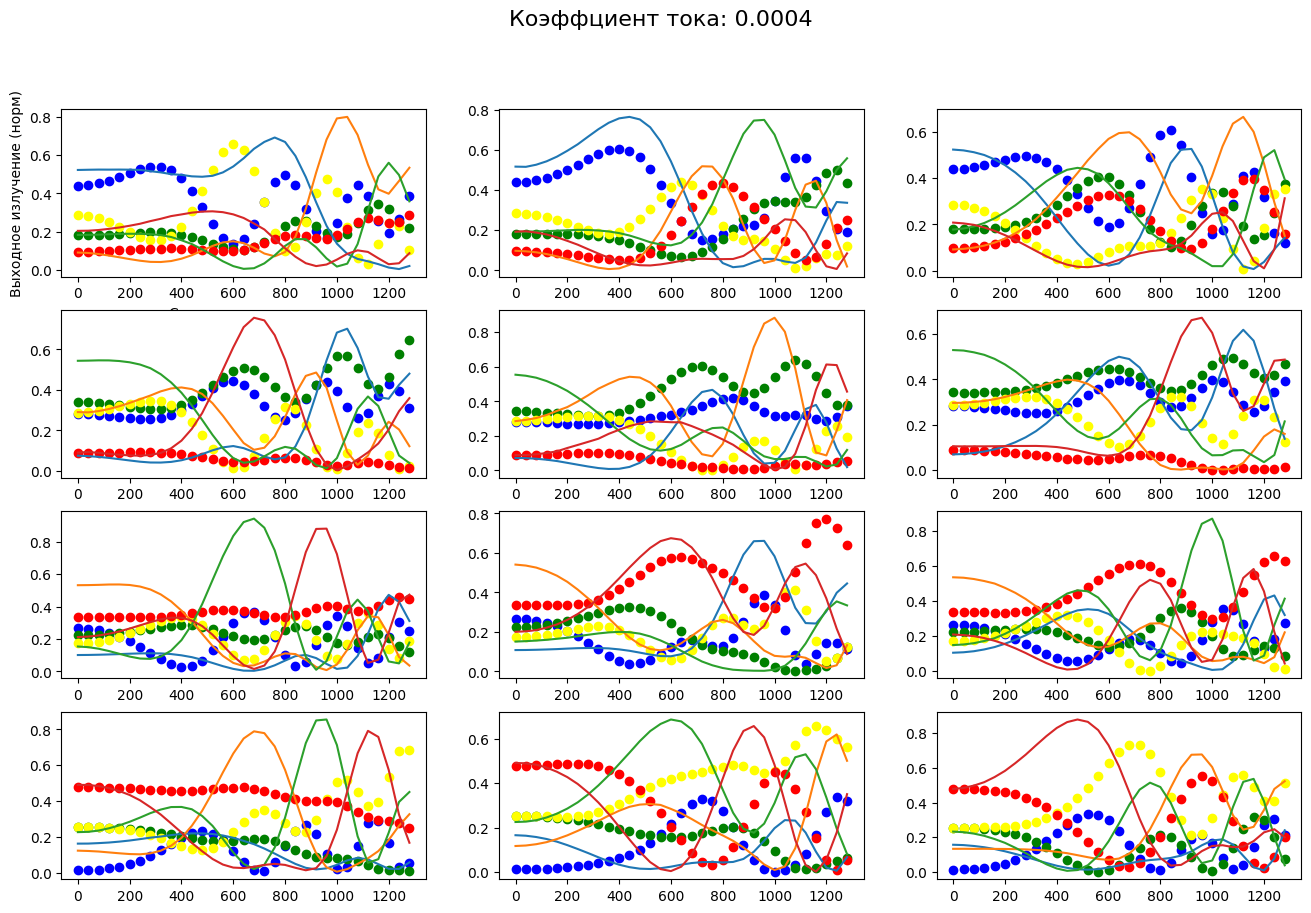

In [ ]:
# x0 = result_basinhop.x
x0 = result.x
# x0 = torch.from_numpy(result.x).to(device=device)
# x0 = torch.randn(42, dtype=torch.float32, device=device)*100

# M1 = create_un_mat_torch(x0[:12], device=device)
# M2 = create_un_mat_torch(x0[12:24], device=device)
# M1 =  Reck_extand_torch(4, x0[:12], device=device)
# M2 =  Reck_extand_torch(4, x0[12:24], device=device)
# alpha = torch.tensor(x0[24:33], dtype=torch.complex128, device=device).reshape(3, 3)
# h_0 = torch.tensor(x0[33:36], dtype=torch.complex128, device=device)
M1 =  Reck_extand(4, x0[:12], x0[12:15])
M2 =  Reck_extand(4, x0[15:27],x0[27:30])
alpha = np.reshape(x0[30:39], (3, 3))
h_0 = x0[39:42]

current_coefficient = 4e-1

fig, ax = plt.subplots(4, 3, figsize=(16, 10))

for j in range(4):
    for k in range(3):

        # for i in data[131*(3*j+k):131*(3*j+k+1)]:
        for i in data[33*(3*j+k):33*(3*j+k+1)]:
            # x = torch.zeros(3, dtype=torch.complex128, device=device)
            # x[i[1]] = (current_coefficient * i[2]) ** 2
            # y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
            # y /= torch.sum(y)

            # h_list = h_0 + alpha @ x
            # H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            # H = torch.diag(H_diag)
            # result_plot = (torch.abs((M2 @ H @ M1).T) ** 2)[i[0]]
            # ax[j][k].scatter(i[2], result_plot[0].cpu().detach().numpy(), color = 'blue')
            # ax[j][k].scatter(i[2], result_plot[1].cpu().detach().numpy(), color = 'green')
            # ax[j][k].scatter(i[2], result_plot[2].cpu().detach().numpy(), color = 'yellow')
            # ax[j][k].scatter(i[2], result_plot[3].cpu().detach().numpy(), color = 'red')

            x = np.zeros(3)
            x[i[1]] = (current_coefficient * i[2]) ** 2
            y = i[3:]
            y /= np.sum(y)

            h_list = h_0 + alpha.dot(np.transpose(x))
            # H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
            result_plot = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
            ax[j][k].scatter(i[2], result_plot[0], color = 'blue')
            ax[j][k].scatter(i[2], result_plot[1], color = 'green')
            ax[j][k].scatter(i[2], result_plot[2], color = 'yellow')
            ax[j][k].scatter(i[2], result_plot[3], color = 'red')

        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[3]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'blue')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[4]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'green')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[5]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'yellow')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[6]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'red')

        ax[0][0].set_xlabel('Сила тока, единицы')
        ax[0][0].set_ylabel('Выходное излучение (норм)')

        fig.suptitle('Фитирование данных Ильи с помощью нашего кода')
        fig.suptitle('Коэффциент тока: ' + str(current_coefficient), fontsize=16)


plt.show()

In [22]:
x0

array([81.80147659, 86.1041447 ,  0.54875617, 50.96397771, 41.94098752,
       22.42701016, 11.88487058, 33.76151714, 94.29097039, 32.3202932 ,
       51.87906217, 70.30189589, 36.36296024, 97.17820827, 96.24472949,
       25.13888642, 49.91309543, 29.77574083, 28.40535214,  3.55500132,
       60.96625362, 50.1268685 ,  5.14787512, 27.86464642, 90.8265886 ,
       23.95618907, 14.48948721, 48.94527603, 98.56504541, 24.20552715,
       67.21129252, 76.16232467, 23.76448492, 72.82362043, 36.77795556,
       63.22933892, 63.3529046 , 53.57878994,  9.02962984, 83.56959273,
       32.20060737, 18.711572  ])